In [1]:
# Suprimir warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Data processing
# ==============================================================================
import openpyxl
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from astral.sun import sun
from astral import LocationInfo
from skforecast.preprocessing import RollingFeatures
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures
from sklearn.preprocessing import StandardScaler
# Plots
# ==============================================================================
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from skforecast.plot import set_dark_theme
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from skforecast.plot import plot_residuals, calculate_lag_autocorrelation
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================

import xgboost
import lightgbm
import catboost
import sklearn
import shap
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from statsmodels.stats.diagnostic import acorr_ljungbox
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
    PolynomialFeatures,
)
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

import skforecast
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    bayesian_search_forecaster,
    backtesting_forecaster,
)
from skforecast.preprocessing import RollingFeatures
from skforecast.feature_selection import select_features
from skforecast.metrics import calculate_coverage

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')
from skforecast.exceptions import DataTransformationWarning

import copy
from sklearn.metrics import mean_squared_error

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión lightgbm: {lightgbm.__version__}")
print(f"{color}Versión xgboost: {xgboost.__version__}")
print(f"{color}Versión catboost: {catboost.__version__}")
print(f"{color}Versión numpy: {np.__version__}")


Versión skforecast: 0.19.1
Versión scikit-learn: 1.7.2
Versión lightgbm: 4.6.0
Versión xgboost: 3.1.3
Versión catboost: 1.2.8
Versión numpy: 2.2.6


In [14]:
# Asegúrate de tener instalada la librería openpyxl
# Si no, ejecuta en tu terminal: pip install openpyxl

df = pd.read_excel("base_diaria_2.xlsx")
df['d'] = pd.to_datetime(df['d'])
df = df.set_index('d')

In [16]:
#Indice y frecuencia
# exog_cols = [col for col in df.columns if col != 'reservas']
df.index = pd.to_datetime(df.index)


# Asegúrate de que el índice esté ordenado antes de asignar frecuencia
df = df.sort_index()

# Aplicar frecuencia diaria
# 'D' completa los días faltantes con NaN si los hubiera
df = df.asfreq('D')

print(f"Frecuencia del índice: {df.index.freq}")




Frecuencia del índice: <Day>


In [5]:
# Configuración del experimento
#fin_train = '2018-12-31'
#fin_validacion = '2021-12-31'
#initial_val_size = len(df.loc[:fin_validacion]) 
#initial_train_size = len(df.loc[:fin_train]) # para cv
#metric = 'mean_absolute_error'
#RANDOM_STATE = 15926

In [18]:
# --- 2. DEFINICIÓN DE PARTICIONES ---
fin_train = '2017-12-31'
fin_validacion = '2021-12-31'
# Usamos df que contiene las nuevas variables
datos_train = df.loc[:fin_train]
datos_val   = df.loc[fin_train : fin_validacion]
datos_test  = df.loc[fin_validacion :]



In [19]:
df.tail()

,base,reservas,base_div_res,var_usd_vs_usd_of,circulacion_monetaria,depositos,prestamos,cer,tasa_badlar,tasa_pase_pasivas_1_dia,...,pasivos_remunerados_total,ratio_pasivos_base,ITCRM,soja_precio,SaldoComercial_MM,EMAE,cambio_gestion,cepo,ministro_nombre,fmi_desembolso
d,,,,,,,,,,,,,,,,,,,,,
2024-04-01,12463695,27127,459.4572,17.7952,8421336.0,78946217,24333398,1,70.875,80.0,...,4045359,0.324571,100.906410,1061.75,216.037502,142.809352,0,1,Luis Caputo,0
2024-04-02,12463695,27127,459.4572,17.7952,8421336.0,78946217,24333398,1,70.875,80.0,...,4045359,0.324571,100.629516,1061.75,216.037502,142.809352,0,1,Luis Caputo,0
2024-04-03,11604677,27882,416.2068,16.6909,8497281.0,79465363,24752512,1,70.750,80.0,...,3110396,0.268030,100.355212,1061.75,216.037502,142.809352,0,1,Luis Caputo,0
2024-04-04,11600629,28400,408.4729,16.0429,8502783.0,79884430,24818111,1,71.500,80.0,...,3100846,0.267300,100.319703,1061.75,216.037502,142.809352,0,1,Luis Caputo,0
2024-04-05,11744788,28765,408.3013,14.1698,8489481.0,80072720,24472455,1,71.375,80.0,...,3258307,0.277426,99.837186,1061.75,216.037502,142.809352,0,1,Luis Caputo,0


In [10]:
#fin_train = '2018-12-31'
#fin_validacion = '2021-12-31'

# Usamos slicing limpio para evitar que el último día de uno sea el primero del otro
#datos_train = df.loc[:fin_train]
#datos_val   = df.loc['2019-01-01':fin_validacion]
#datos_test  = df.loc['2022-01-01':]

#print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
#print(f"Fechas validación : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
#print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

In [20]:
df.columns

Index(['base', 'reservas', 'base_div_res', 'var_usd_vs_usd_of',
       'circulacion_monetaria', 'depositos', 'prestamos', 'cer', 'tasa_badlar',
       'tasa_pase_pasivas_1_dia', 'inflacion_mensual_oficial',
       'inflacion_esperada_oficial', 'merval_usd', 'sp500', 'vix_index',
       'pasivos_remunerados_total', 'ratio_pasivos_base', 'ITCRM',
       'soja_precio', 'SaldoComercial_MM', 'EMAE', 'cambio_gestion', 'cepo',
       'ministro_nombre', 'fmi_desembolso'],
      dtype='object')

In [21]:
# 1. Definimos los grupos de variables
vars_mensuales = [
    'inflacion_mensual_oficial', 'inflacion_esperada_oficial', 
    'EMAE', 'SaldoComercial_MM', 'fmi_desembolso'
]

# El resto son diarias (incluyendo las financieras y monetarias)
vars_diarias = [
    'base', 'reservas', 'base_div_res', 'var_usd_vs_usd_of',
    'circulacion_monetaria', 'depositos', 'prestamos', 'cer', 'tasa_badlar',
    'tasa_pase_pasivas_1_dia', 'merval_usd', 'sp500', 'vix_index',
    'pasivos_remunerados_total', 'ratio_pasivos_base', 
    'ITCRM', 'soja_precio'
]

# 3. Caso especial: Variables categóricas o de estado (Cepo, Ministro, etc.)
# Generalmente estas también se desfasan 1 día si quieres ver el impacto al día siguiente
vars_estado = ['cambio_gestion', 'cepo', 'ministro_nombre']

# --- PROCESAMIENTO CON PROTECCIÓN DE TARGET ---

# 1. Variables diarias (Protegiendo 'reservas')
for col in vars_diarias:
    df[f'{col}_lag1'] = df[col].shift(1)
    # Solo eliminamos si NO es el target
    if col != 'reservas':
        df.drop(columns=[col], inplace=True)

# 2. Variables mensuales
for col in vars_mensuales:
    serie_mensual = df[col].resample('MS').first()
    serie_lag_mensual = serie_mensual.shift(1)
    df[f'{col}_lag1'] = df.index.to_period('M').map(serie_lag_mensual.to_period('M'))
    df.drop(columns=[col], inplace=True)

# 3. Variables de estado
for col in vars_estado:
    df[f'{col}_lag1'] = df[col].shift(1)
    df.drop(columns=[col], inplace=True)

# Limpieza de nulos iniciales
df.dropna(inplace=True)

print("Estructura de datos lista.")
print(f"Target detectado: {'reservas' in df.columns}")
print(f"Predictores (ejemplos): {[c for c in df.columns if 'lag1' in c][:5]}")

Estructura de datos lista.
Target detectado: True
Predictores (ejemplos): ['base_lag1', 'reservas_lag1', 'base_div_res_lag1', 'var_usd_vs_usd_of_lag1', 'circulacion_monetaria_lag1']


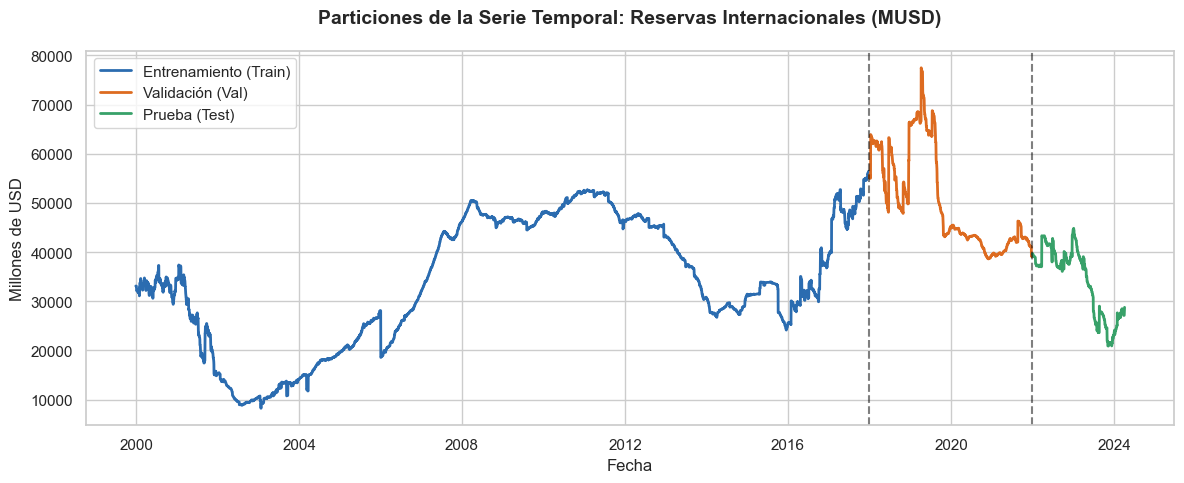

In [22]:

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))

# Graficamos cada segmento
plt.plot(datos_train.index, datos_train['reservas'], label='Entrenamiento (Train)', color='#2b6cb0', linewidth=2)
plt.plot(datos_val.index, datos_val['reservas'], label='Validación (Val)', color='#dd6b20', linewidth=2)
plt.plot(datos_test.index, datos_test['reservas'], label='Prueba (Test)', color='#38a169', linewidth=2)

# Líneas divisorias basadas en la configuración
plt.axvline(pd.to_datetime(fin_train), color='black', linestyle='--', alpha=0.5)
plt.axvline(pd.to_datetime(fin_validacion), color='black', linestyle='--', alpha=0.5)

# Estética
plt.title('Particiones de la Serie Temporal: Reservas Internacionales (MUSD)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Millones de USD', fontsize=12)
plt.legend(frameon=True, loc='upper left')

plt.tight_layout()
plt.show()

In [23]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, title):
    print(f'--- Test Dickey-Fuller: {title} ---')
    # dropna() es fundamental porque el test no acepta valores nulos
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f'Estadístico ADF: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    if result[1] <= 0.05:
        print("Resultado: Estacionaria (Rechazamos H0)")
    else:
        print("Resultado: No estacionaria (No rechazamos H0)")
    print("-" * 30)

# 1. Test en Niveles (Original)
test_stationarity(df['reservas'], "Reservas en Niveles")

# 2. Test en Primera Diferencia
test_stationarity(df['reservas'].diff(), "Reservas en 1° Diferencia")

# 3. Test en Segunda Diferencia (Solo si la anterior dio No Estacionaria)
# test_stationarity(df['reservas'].diff().diff(), "Reservas en 2° Diferencia")

--- Test Dickey-Fuller: Reservas en Niveles ---
Estadístico ADF: -2.2055
p-value: 0.2042
Valores Críticos:
   1%: -3.4313
   5%: -2.8620
   10%: -2.5670
Resultado: No estacionaria (No rechazamos H0)
------------------------------
--- Test Dickey-Fuller: Reservas en 1° Diferencia ---
Estadístico ADF: -38.2659
p-value: 0.0000
Valores Críticos:
   1%: -3.4313
   5%: -2.8620
   10%: -2.5670
Resultado: Estacionaria (Rechazamos H0)
------------------------------


# Definicion de Variables

In [24]:
# Actualizamos los tamaños para tu configuración de CV
initial_train_size = len(df.loc[:fin_train])
initial_val_size = len(df.loc[:fin_validacion])

In [26]:
# --- PASO AUTOMATIZADO ---

# 1. Identificar el Target
target = 'reservas'

# 2. Identificar Categóricas Automáticamente
# Buscamos columnas que terminen en '_lag1' Y que originalmente sean tipo objeto o categoria
# O aquellas que sabemos que son de 'estado' aunque sean numéricas
vars_categoricas = [
    col for col in df.columns 
    if col.endswith('_lag1') and (df[col].dtype == 'object' or col.startswith(('cepo', 'cambio_gestion', 'ministro')))
]

# 3. Identificar Numéricas Automáticamente
# Son las que tienen '_lag1' pero no están en la lista de categóricas
vars_numericas = [
    col for col in df.columns 
    if col.endswith('_lag1') and col not in vars_categoricas
]

# 4. Aplicar el tipo 'category' solo a las detectadas
for col in vars_categoricas:
    df[col] = df[col].astype('category')

# 5. Definir exog_cols de forma dinámica
exog_cols = vars_categoricas + vars_numericas

print(f"Detección Automática:")
print(f"Categorical features: {vars_categoricas}")
print(f"Numerical features count: {len(vars_numericas)}")

Detección Automática:
Categorical features: ['cambio_gestion_lag1', 'cepo_lag1', 'ministro_nombre_lag1']
Numerical features count: 22


In [131]:
df[vars_numericas].columns

Index(['base_lag1', 'reservas_lag1', 'base_div_res_lag1',
       'var_usd_vs_usd_of_lag1', 'circulacion_monetaria_lag1',
       'depositos_lag1', 'prestamos_lag1', 'cer_lag1', 'tasa_badlar_lag1',
       'tasa_pase_pasivas_1_dia_lag1', 'merval_usd_lag1', 'sp500_lag1',
       'vix_index_lag1', 'pasivos_remunerados_total_lag1',
       'ratio_pasivos_base_lag1', 'ITCRM_lag1', 'soja_precio_lag1',
       'inflacion_mensual_oficial_lag1', 'inflacion_esperada_oficial_lag1',
       'EMAE_lag1', 'SaldoComercial_MM_lag1', 'fmi_desembolso_lag1'],
      dtype='object')

In [ ]:
df.corr

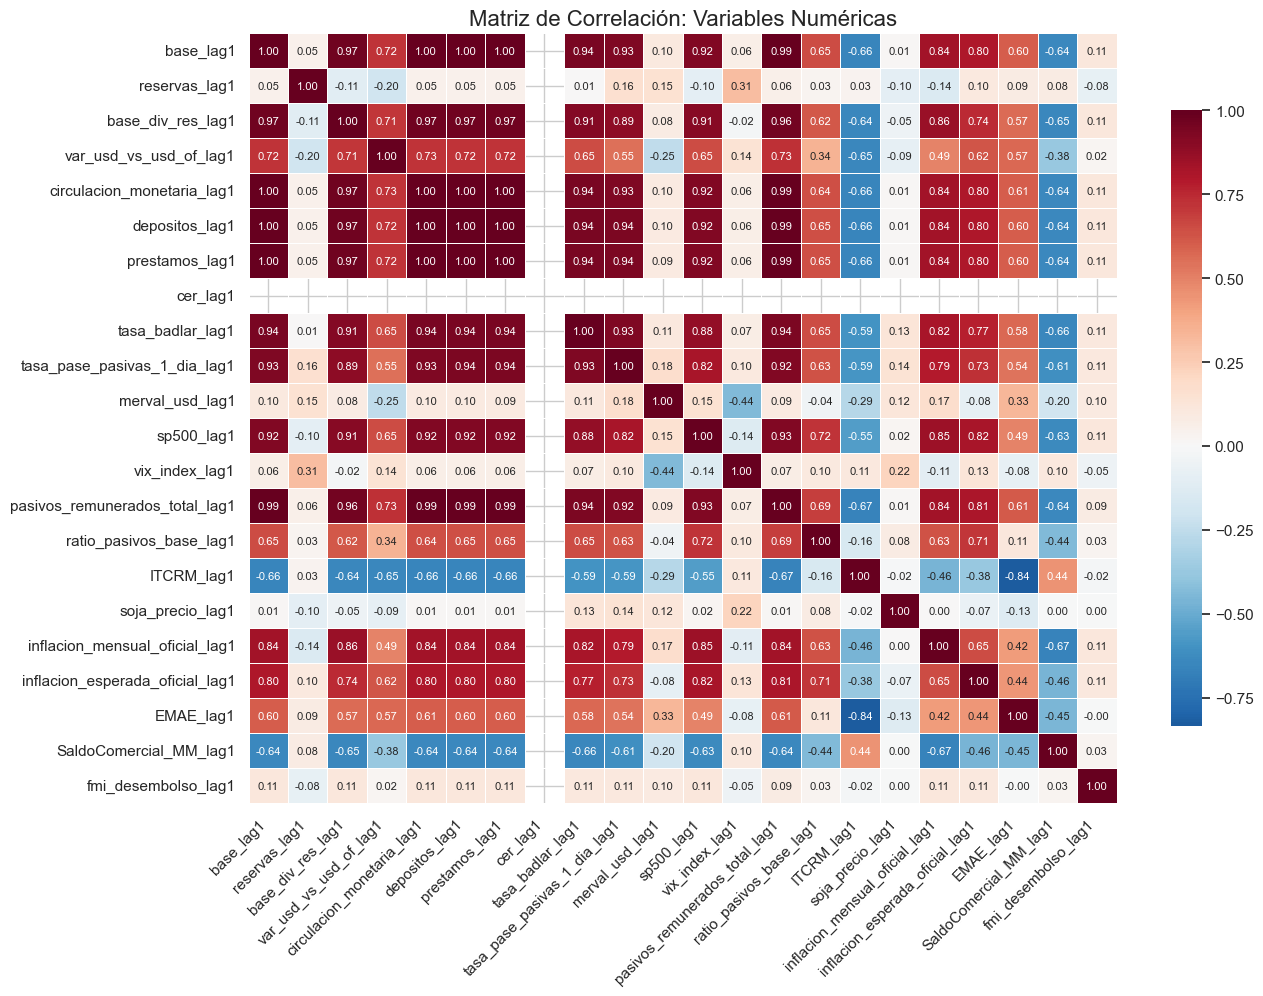

In [141]:
# 4. Configuramos el gráfico
mask = np.triu(np.ones_like(df[vars_numericas].corr(method="spearman"), dtype=bool))
plt.figure(figsize=(14, 10))
sns.heatmap(
    df[vars_numericas].corr(method="spearman"), 
    annot=True,           # <--- AHORA SÍ: Muestra los números
    fmt=".2f",            # Dos decimales
    annot_kws={"size": 8}, # Tamaño de letra de los números para que no se pisen
    cmap='RdBu_r', 
    center=0,
    linewidths=.5, 
    cbar_kws={"shrink": .8}
)
plt.title('Matriz de Correlación: Variables Numéricas', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

In [175]:
vars_numericas_filtradas

['base_lag1',
 'reservas_lag1',
 'var_usd_vs_usd_of_lag1',
 'cer_lag1',
 'tasa_badlar_lag1',
 'merval_usd_lag1',
 'sp500_lag1',
 'vix_index_lag1',
 'pasivos_remunerados_total_lag1',
 'ratio_pasivos_base_lag1',
 'ITCRM_lag1',
 'soja_precio_lag1',
 'inflacion_mensual_oficial_lag1',
 'EMAE_lag1',
 'SaldoComercial_MM_lag1',
 'fmi_desembolso_lag1']

In [142]:
# Ejemplo rápido para filtrar variables redundantes
corr_matrix = df[vars_numericas].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
vars_numericas_filtradas = [c for c in vars_numericas if c not in to_drop]
vars_numericas = vars_numericas_filtradas

## Atraso de numericas

In [143]:
# Desplazamos solo las económicas
#df[vars_numericas] = df[vars_numericas].shift(1)
#df = df.dropna() # Limpiamos la fila vacía que deja el shift

In [144]:
# Transformador de exogenas
#transformer_exog = make_column_transformer(
#    (OrdinalEncoder(), vars_categoricas),
#    remainder="passthrough", # Deja a las numericas como esta en teoria
#    verbose_feature_names_out=False
#).set_output(transform="pandas")

# Columnas de exogenas
#exog_cols = vars_categoricas + vars_numericas

In [145]:
transformer_exog = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), vars_categoricas),
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

# Columnas de exogenas
exog_cols = vars_categoricas + vars_numericas

In [146]:
df.shape

(7004, 59)

In [147]:
df[exog_cols]

,cambio_gestion_lag1,cepo_lag1,ministro_nombre_lag1,base_lag1,reservas_lag1,var_usd_vs_usd_of_lag1,cer_lag1,tasa_badlar_lag1,merval_usd_lag1,sp500_lag1,vix_index_lag1,pasivos_remunerados_total_lag1,ratio_pasivos_base_lag1,ITCRM_lag1,soja_precio_lag1,inflacion_mensual_oficial_lag1,EMAE_lag1,SaldoComercial_MM_lag1,fmi_desembolso_lag1
d,,,,,,,,,,,,,,,,,,,
2005-02-01,0.0,0.0,Roberto Lavagna,49363.0,20137.0,0.2560,1.0,2.8750,467.673,1181.270020,12.82,13685.0,0.277232,163.055014,792.75,0.8,102.717123,85.339677,0.0
2005-02-02,0.0,0.0,Roberto Lavagna,50199.0,20221.0,0.2568,1.0,3.0000,469.141,1189.410034,12.03,14391.0,0.286679,163.070604,792.75,0.8,102.717123,85.339677,0.0
2005-02-03,0.0,0.0,Roberto Lavagna,49141.0,20330.0,0.2568,1.0,3.0625,468.325,1193.189941,11.66,13180.0,0.268208,163.001899,792.50,0.8,102.717123,85.339677,0.0
2005-02-04,0.0,0.0,Roberto Lavagna,49295.0,20322.0,0.1712,1.0,2.8750,478.369,1189.890015,11.79,13103.0,0.265808,162.868782,800.50,0.8,102.717123,85.339677,0.0
2005-02-05,0.0,0.0,Roberto Lavagna,49517.0,20182.0,0.1712,1.0,2.8750,488.390,1203.030029,11.21,13123.0,0.265020,162.416288,793.25,0.8,102.717123,85.339677,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,0.0,1.0,Luis Caputo,12463695.0,27127.0,17.7952,1.0,70.8750,1200.220,5254.350098,13.01,4045359.0,0.324571,101.184066,1061.75,13.2,143.685868,0.001432,0.0
2024-04-02,0.0,1.0,Luis Caputo,12463695.0,27127.0,17.7952,1.0,70.8750,1200.220,5243.770020,13.65,4045359.0,0.324571,100.906410,1061.75,13.2,143.685868,0.001432,0.0
2024-04-03,0.0,1.0,Luis Caputo,12463695.0,27127.0,17.7952,1.0,70.8750,1200.220,5205.810059,14.61,4045359.0,0.324571,100.629516,1061.75,13.2,143.685868,0.001432,0.0


In [148]:
# Definir el transformador logarítmico
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

# Primera corrida

In [149]:
metric = 'mean_absolute_error'
differentiation = 1
refit = 15

In [150]:

stats_list = ["std", "max", "min","mean"] 
sizes_list = [7, 30] 
stats_all = [s for s in stats_list for _ in sizes_list]
sizes_all = sizes_list * len(stats_list)

# Definición final
window_features = RollingFeatures(stats=stats_all, window_sizes=sizes_all)
# ==============================================================================
forecaster = ForecasterRecursive(
                estimator        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = [1,7,30],
                transformer_y    = StandardScaler(),
                window_features  = window_features,
                transformer_exog = transformer_exog,
                differentiation  =differentiation)

cv = TimeSeriesFold(
    steps = 1, # Cambiamos a 1 para que prediga mes a mes de forma realista
    initial_train_size = initial_train_size,
    differentiation  =differentiation
)

metrica, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = df['reservas'], 
    exog       = df[exog_cols],       
    cv         = cv,
    metric     = metric
)
metrica

  0%|          | 0/2287 [00:00<?, ?it/s]

,mean_absolute_error
0,319.790591


# Eliminacion de variables

In [151]:
# 1. Definimos el estimador usando los "mejores parámetros" que encontramos
# Estimador ROBUSTO para selección de features (no el óptimo), Supongo?

import warnings

from skforecast import feature_selection
warnings.filterwarnings('ignore')
# ==============================================================================
estimator_selector = LGBMRegressor(
n_estimators  = 500,        # Más árboles para encontrar relaciones sutiles
    learning_rate = 0.01,       # Tasa más baja para aprender despacio y no solo el Lag1
    max_depth     = 5,          # Un poco más profundo para permitir interacciones (Exog + Lag)
    num_leaves    = 31,         # Estándar para max_depth=5
    colsample_bytree = 0.8,     # Obliga a cada árbol a mirar diferentes variables (no siempre el Lag1)
    reg_alpha     = 0.1,        # Regularización L1 para limpiar ruido
    random_state  = 123,
    verbose       = -1,
    importance_type = 'gain'
)

forecaster = ForecasterRecursive(
    estimator        = estimator_selector,
    lags             = [1, 2, 3,4,6,5, 7, 14, 30, 60, 90, 180, 365],       
    transformer_y    = StandardScaler(),
    transformer_exog = transformer_exog, 
    differentiation  = differentiation,
    window_features = window_features
)
# 3. Configuramos el selector RFECV
# Aca con TimeSeriesSplit(n_splits=3) Logra funcionar bien
selector = RFECV(
    estimator = estimator_selector,  # ← Usa el simple
    step      = 0.1,
    cv        = TimeSeriesSplit(n_splits=7),
    scoring   = 'neg_mean_absolute_error',
    min_features_to_select = 10,
)
# 4. Ejecutamos la selección de variables
# USAMOS TODO EL CONJUNTO DE ENTRENAMIENTO (datos_validacion)
lags_sel, window_sel, exog_sel = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = df.loc[:, 'reservas'],
    exog            = df.loc[:, exog_cols],
    subsample       = 1.0, # Con 300 datos, usamos el 100% (es rápido)
    random_state    = 123,
    verbose         = True,

    
)

# 5. RESULTADOS: ¿Quién sobrevivió al "Gran Filtro"?
print(f"Lags seleccionados: {lags_sel}")
print(f"Ventanas seleccionadas: {window_sel}")
print(f"Exógenas seleccionadas: {exog_sel}")

final_window_features = window_features if len(window_sel) > 0 else None

Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 6638
Total number of records used for feature selection: 6638
Number of features available: 40
    Lags            (n=13)
    Window features (n=8)
    Exog            (n=19)
Number of features selected: 28
    Lags            (n=10) : [1, 4, 5, 6, 7, 14, 30, 60, 90, 365]
    Window features (n=5) : ['roll_std_7', 'roll_std_30', 'roll_max_7', 'roll_mean_7', 'roll_mean_30']
    Exog            (n=13) : ['base_lag1', 'reservas_lag1', 'var_usd_vs_usd_of_lag1', 'tasa_badlar_lag1', 'merval_usd_lag1', 'sp500_lag1', 'vix_index_lag1', 'pasivos_remunerados_total_lag1', 'ratio_pasivos_base_lag1', 'ITCRM_lag1', 'inflacion_mensual_oficial_lag1', 'EMAE_lag1', 'SaldoComercial_MM_lag1']
Lags seleccionados: [1, 4, 5, 6, 7, 14, 30, 60, 90, 365]
Ventanas seleccionadas: ['roll_std_7', 'roll_std_30', 'roll_max_7', 'roll_mean_7', 'roll_mean_30']
Exógenas seleccionadas: ['base_lag1', 'reservas_lag1

In [152]:
# Filtramos para quedarnos solo con las categóricas que están en exog_sel
vars_categoricas_sel = [v for v in vars_categoricas if v in exog_sel]

# Creamos un NUEVO transformador con solo esas variables
transformer_exog_sel = make_column_transformer(
    (OrdinalEncoder(), vars_categoricas_sel),
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

# 3. Crear el forecaster con el transformador corregido
# ==============================================================================
forecaster = ForecasterRecursive(
    estimator        = estimator_selector,
    lags             = lags_sel,        
    window_features  = final_window_features,
    transformer_y    = log_transformer,
    transformer_exog = transformer_exog_sel,
    differentiation  = differentiation
)

# 4. Ejecutar el Backtesting
# ==============================================================================
cv = TimeSeriesFold(
    steps              = 5,
    initial_train_size = initial_train_size,
     differentiation = differentiation,
     refit = refit
)

metrica_lgbm, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = df.loc[:fin_validacion,'reservas'],
    exog       = df.loc[:fin_validacion,exog_sel], 
    cv         = cv,
    metric     = 'mean_absolute_error'
)

print(f"Métrica MAE con predictores seleccionados: {metrica_lgbm}")

  0%|          | 0/293 [00:00<?, ?it/s]

Métrica MAE con predictores seleccionados:    mean_absolute_error
0           616.450837


# Definicion para busqueda de Hiperparametros
### Para datos hasta train

In [153]:
# 1. Definimos los Lags que queremos probar
# Definimos combinaciones estratégicas para Argentina
# Creamos una lista de combinaciones basadas en tus 5 ganadores
import itertools

# Supongamos que lags_sel = [1, 2, 4, 7, 30] (lo que salió de tu RFECV)
# Generamos combinaciones de distinto tamaño
lags_grid = []

# Queremos combinaciones de al menos 2 lags hasta el total de lags_sel
for r in range(2, len(lags_sel) + 1):
    combinations = list(itertools.combinations(lags_sel, r))
    # Convertimos cada tupla en lista para que skforecast la acepte
    lags_grid.extend([list(c) for c in combinations])

# Si la lista es muy larga (ej. más de 20), podemos quedarnos con una muestra aleatoria 
# o las que incluyan sí o sí los lags más cortos (1 o 2)
print(f"Se generaron {len(lags_grid)} combinaciones para el Bayesiano.")

def search_space(trial):
    return {
        'n_estimators'  : trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'lags'          : trial.suggest_categorical('lags', lags_grid) # <--- Aquí los pasas
    }

def search_space(trial):
    return {
        # n_estimators: Cuántos árboles construye. 
        # Para 300 datos, entre 100 y 500 es suficiente.
        'n_estimators'    : trial.suggest_int('n_estimators', 100, 1000, step=100),
        
        # max_depth: Qué tan complejo es cada árbol. 
        # Queremos árboles simples (3 a 7) para evitar el sobreajuste.
        'max_depth'       : trial.suggest_int('max_depth', 3, 10),
        
        # learning_rate: Qué tan rápido aprende. 
        # Un valor bajo (0.01 a 0.1) suele ser más robusto.
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.1,log=True),
        
        # lags: Dejamos que el algoritmo elija cuál de las listas de arriba funciona mejor.
        'lags'            : trial.suggest_categorical('lags', lags_grid),
        # Parámetros extra para LightGBM (opcional pero ayuda con los picos)
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1)
    }

Se generaron 1013 combinaciones para el Bayesiano.


In [154]:
# ACA cambia algo antes era  initial_train_size = len(datos_train),
#  Plan de validación para la búsqueda (Evaluamos en el periodo 2019-2021)
cv_search = TimeSeriesFold(
    steps = 5, 
    initial_train_size = initial_train_size, # Hasta 2018
    differentiation = differentiation,
    refit = refit
)

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = df.loc[:fin_validacion, 'reservas'],
    exog          = df.loc[:fin_validacion, exog_sel],
    cv            = cv_search,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 30,
    random_state  = 123,
    return_best   = True,
)

best_params = results_search['params'].iat[0]
best_params = best_params | {'random_state': 15926, 'verbose': -1}
best_lags   = results_search['lags'].iat[0]

  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  4   5   6  30  90 365] 
  Parameters: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.04269858981238957, 'reg_alpha': 0.5745920483619711, 'reg_lambda': 0.4056074582053503}
  Backtesting metric: 430.168681574381


In [155]:
results_search.head(3)

,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,reg_alpha,reg_lambda
0,"[4, 5, 6, 30, 90, 365]","{'n_estimators': 800, 'max_depth': 5, 'learnin...",430.168682,800.0,5.0,0.042699,0.574592,0.405607
1,"[4, 5, 6, 14, 30, 365]","{'n_estimators': 1000, 'max_depth': 3, 'learni...",431.576220,1000.0,3.0,0.010682,0.705622,0.694262
2,"[4, 5, 6, 7, 30, 365]","{'n_estimators': 1000, 'max_depth': 3, 'learni...",432.384779,1000.0,3.0,0.025029,0.718170,0.391758


# POST BAYESIANO

In [156]:


cv = TimeSeriesFold(
    steps = 1, # Mes a mes
    initial_train_size = initial_train_size,
    differentiation = differentiation,
    refit = refit
)

# 1. Definimos el Forecaster con TODO lo que ganó el Bayesiano
forecaster = ForecasterRecursive(
    estimator        = LGBMRegressor(**best_params),
    lags             = best_lags,        
    window_features  = window_features,
    transformer_y    = log_transformer,
    transformer_exog = transformer_exog_sel, 
    differentiation  = differentiation
)

# 2. Ejecutamos el backtesting sobre el periodo de TEST (2022+)
metrica, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = df['reservas'],
    exog       = df[exog_sel],
    cv         = cv, # Ahora con fin_validacion
    metric     = 'mean_absolute_error'
)

print(f"MAE Final en periodo de TEST: {metrica}")


# X esto no dan lo mismo
#metrica_val, predicciones_val = backtesting_forecaster(
#    forecaster = forecaster,
#    y          = df.loc[:fin_validacion, 'reservas_musd'], # Solo hasta validación
#    exog       = df.loc[:fin_validacion, exog_cols],
#    cv         = cv_search, # Usa el mismo CV de la búsqueda
#    metric     = 'mean_absolute_error'
#)
#print(f"Error en validación: {metrica_val}")

  0%|          | 0/2287 [00:00<?, ?it/s]

MAE Final en periodo de TEST:    mean_absolute_error
0           155.530561


# COMIENZO DE INTERVALOS Y CORREACION OUT SAMPLE


In [157]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    estimator        = LGBMRegressor(**best_params),
    lags             = best_lags,        # <--- CORREGIDO
    window_features  = window_features,
    transformer_y    = log_transformer,
    transformer_exog = transformer_exog_sel, # <--- CORREGIDO (No lo olvides!)
    differentiation  = differentiation
)
# Entrenamos con datos hasta fin_train (2018)
forecaster.fit(
    y    = df.loc[:fin_train, 'reservas'],
    exog = df.loc[:fin_train, exog_sel],
    store_in_sample_residuals = True
)


In [158]:
# Silenciamos solo este aviso específico
from numpy import diff


warnings.filterwarnings('ignore', category=DataTransformationWarning)

# Backtesting con intervalos de predicción en test usando out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(steps = 1, initial_train_size = initial_train_size, differentiation = differentiation, refit = refit)
metrica, predicciones = backtesting_forecaster(
   forecaster              = forecaster,
   y                       = df['reservas'],
   exog                    = df[exog_sel],
   cv                      = cv,
   metric                  = 'mean_absolute_error',
   interval                = [5, 95],
   interval_method         = 'conformal',
   use_in_sample_residuals = True,   # <--- CAMBIA A TRUE
   use_binned_residuals    = True,   # Ahora sí funcionará porque el refit genera los bins
   return_predictors       = True,
   verbose                 = False
)
print(metrica)
predicciones.head(5)


  0%|          | 0/2287 [00:00<?, ?it/s]

   mean_absolute_error
0           155.530561


,fold,pred,lower_bound,upper_bound,lag_4,lag_5,lag_6,lag_30,lag_90,lag_365,...,tasa_badlar_lag1,merval_usd_lag1,sp500_lag1,vix_index_lag1,pasivos_remunerados_total_lag1,ratio_pasivos_base_lag1,ITCRM_lag1,inflacion_mensual_oficial_lag1,EMAE_lag1,SaldoComercial_MM_lag1
2018-01-01,0,55079.340994,54809.967075,55350.038777,-0.002330,-0.001048,-0.001348,0.000000,0.000178,0.000000,...,23.2500,1555.50,2673.610107,11.04,214400.0,0.214162,90.704508,1.4,152.536775,-1.494000e-10
2018-01-02,1,55079.614935,54810.239676,55350.314064,-0.019676,-0.002330,-0.001048,0.000000,0.001401,-0.000305,...,23.2500,1555.50,2673.610107,11.04,214400.0,0.214162,90.660151,1.4,152.536775,-1.494000e-10
2018-01-03,2,55751.376008,55538.019003,55965.552637,0.000000,-0.019676,-0.002330,-0.001020,0.002382,0.004823,...,23.0625,1555.50,2695.810059,9.77,289469.0,0.268382,90.089106,1.4,152.536775,-1.494000e-10
2018-01-04,3,55726.366867,55513.105570,55940.447423,0.000000,0.000000,-0.019676,-0.001825,0.000256,0.002378,...,23.2500,1631.74,2713.060059,9.15,273178.0,0.257168,90.321782,1.4,152.536775,-1.494000e-10
2018-01-05,4,55651.700276,55379.527197,55925.210975,0.000000,0.000000,0.000000,0.001223,0.000000,0.006949,...,23.1250,1646.16,2723.989990,9.22,256705.0,0.245566,91.421144,1.4,152.536775,-1.494000e-10


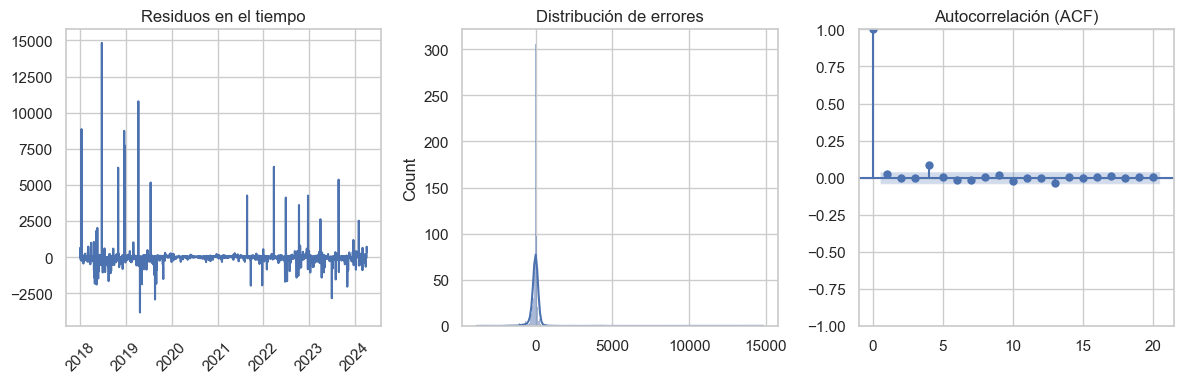

In [159]:
# 1. Calculamos los residuos
residuals = df.loc[predicciones.index, 'reservas'] - predicciones['pred']

# 2. Creamos el lienzo manualmente (3 gráficos)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Gráfico 1: Residuos en el tiempo
axs[0].plot(residuals)
axs[0].set_title("Residuos en el tiempo")
axs[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Distribución (Histograma)
sns.histplot(residuals, kde=True, ax=axs[1])
axs[1].set_title("Distribución de errores")

# Gráfico 3: Autocorrelación (ACF) 
plot_acf(residuals, ax=axs[2], lags=20) 
axs[2].set_title("Autocorrelación (ACF)")

plt.tight_layout()
plt.show()

In [160]:
# Almacenar residuos out-sample en el forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = df.loc[predicciones.index, 'reservas'],
    y_pred = predicciones['pred']
)


In [161]:
pred_niveles  = predicciones['pred']
real_niveles  = df.loc[predicciones.index, 'reservas']

if 'lower_bound' in predicciones.columns:
    lower_niveles = predicciones['lower_bound']
    upper_niveles = predicciones['upper_bound']
# ==============================================================================
fig = go.Figure([
    # 1. Línea de Predicción Puntual
    go.Scatter(
        name = 'Predicción (Nivel)', 
        x    = predicciones.index, 
        y    = pred_niveles, 
        mode = 'lines',
        line = dict(color='blue', width=2)
    ),
    # 2. Línea de Valor Real
    go.Scatter(
        name = 'Valor Real', 
        x    = predicciones.index, 
        y    = real_niveles, 
        mode = 'lines',
        line = dict(color='orange', width=2)
    )
])

# 3. Agregar el sombreado solo si existen los intervalos
if 'lower_bound' in predicciones.columns:
    fig.add_traces([
        go.Scatter(
            name='Intervalo Superior', x=predicciones.index, y=upper_niveles,
            mode='lines', line=dict(width=0), showlegend=False
        ),
        go.Scatter(
            name='Intervalo Inferior', x=predicciones.index, y=lower_niveles,
            mode='lines', line=dict(width=0), fillcolor='rgba(100, 100, 100, 0.2)',
            fill='tonexty', showlegend=False
        )
    ])

# Configuración del diseño (Actualizamos el título)
fig.update_layout(
    title       = '<b>Reservas Totales: Valor Real vs Predicción (Diferenciación Automática)</b>',
    xaxis_title = "Fecha",
    yaxis_title = "Millones de USD (mUSD)",
    width       = 950,
    height      = 500,
    template    = "seaborn",
    hovermode   = "x unified"
)

fig.show()

In [162]:
# 1. Calcular Cobertura en Niveles
# ==============================================================================
cobertura_niveles = calculate_coverage(
    y_true      = real_niveles,
    lower_bound = lower_niveles,
    upper_bound = upper_niveles
)

# 2. Calcular el Ancho Promedio de la Banda (en millones de USD)
# ==============================================================================
ancho_banda = (upper_niveles - lower_niveles).mean()

print(f"Cobertura del intervalo (Niveles): {round(100 * cobertura_niveles, 2)} %")
print(f"Ancho promedio de la banda: {round(ancho_banda, 2)} mUSD")

Cobertura del intervalo (Niveles): 85.05 %
Ancho promedio de la banda: 401.0 mUSD


In [163]:
# Crear y entrenar el forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    estimator        = LGBMRegressor(**best_params),
    lags             = best_lags,
    window_features  = window_features,
    transformer_y    = log_transformer,
    transformer_exog = transformer_exog_sel,
    differentiation  = 1
)
forecaster.fit(
    y    = df.loc[:fin_validacion, 'reservas'],
    exog = df.loc[:fin_validacion, exog_sel]
)


In [178]:
# Extraer importancia de los predictores
# ==============================================================================
importancia = forecaster.get_feature_importances()
importancia.head(30)


,feature,importance
18,merval_usd_lag1,111
20,vix_index_lag1,100
16,var_usd_vs_usd_of_lag1,83
12,roll_mean_7,65
7,roll_std_30,65
3,lag_30,64
5,lag_365,63
15,reservas_lag1,62
0,lag_4,53
1,lag_5,53


In [165]:
# Matrices de entrenamiento utilizadas por el forecaster para entrenar el regresor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                        y    = df.loc[:fin_validacion, 'reservas'],
                        exog = df.loc[:fin_validacion, exog_sel]
                    )
display(X_train.head(3))
display(y_train.head(3))


,lag_4,lag_5,lag_6,lag_30,lag_90,lag_365,roll_std_7,roll_std_30,roll_max_7,roll_max_30,...,tasa_badlar_lag1,merval_usd_lag1,sp500_lag1,vix_index_lag1,pasivos_remunerados_total_lag1,ratio_pasivos_base_lag1,ITCRM_lag1,inflacion_mensual_oficial_lag1,EMAE_lag1,SaldoComercial_MM_lag1
d,,,,,,,,,,,,,,,,,,,,,
2006-02-02,0.000000,0.000000,0.002766,-0.412882,-0.007682,0.005376,0.004760,0.075942,0.01407,0.017297,...,7.9375,572.036,1282.459961,12.36,12510.0,0.211360,166.499274,1.1,112.908242,0.000011
2006-02-03,0.003166,0.000000,0.000000,-0.000108,0.000000,-0.000394,0.004863,0.004024,0.01407,0.017297,...,7.9375,565.018,1270.839966,13.23,11853.0,0.201332,166.422791,1.1,112.908242,0.000011
2006-02-04,0.004020,0.003166,0.000000,0.002527,0.000000,-0.006913,0.005961,0.004250,0.01407,0.017297,...,8.1250,550.011,1264.030029,12.96,11805.0,0.199723,166.384671,1.1,112.908242,0.000011


d
2006-02-02    0.001301
2006-02-03   -0.005416
2006-02-04    0.000000
Freq: D, Name: y, dtype: float64

In [166]:
explainer = shap.TreeExplainer(forecaster.estimator)

# Se selecciona una muestra del 50% de los datos para acelerar el cálculo
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)


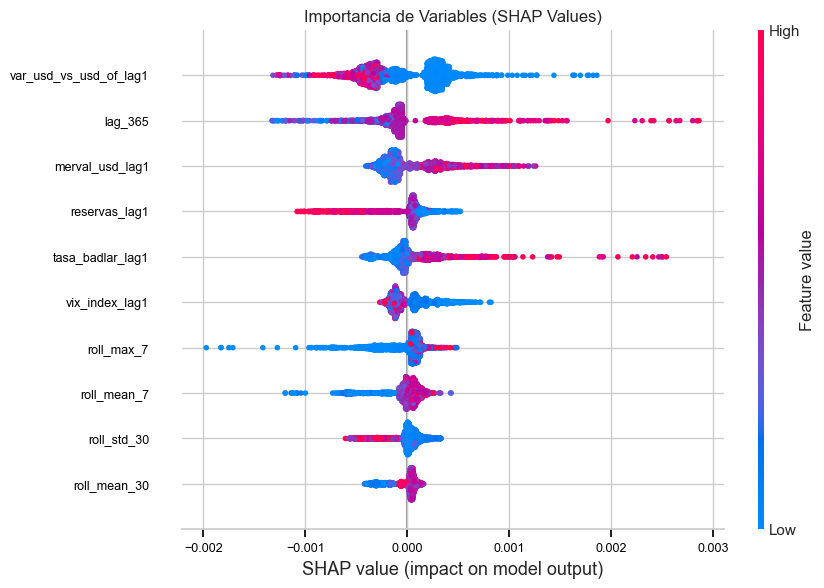

In [167]:
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_title("Importancia de Variables (SHAP Values)", fontsize=12)

ax.tick_params(labelsize=9, colors='black') 

plt.gcf().subplots_adjust(left=0.3) 

fig.set_size_inches(10, 6)
plt.show()

In [168]:
predicciones.head(3)


,fold,pred,lower_bound,upper_bound,lag_4,lag_5,lag_6,lag_30,lag_90,lag_365,...,tasa_badlar_lag1,merval_usd_lag1,sp500_lag1,vix_index_lag1,pasivos_remunerados_total_lag1,ratio_pasivos_base_lag1,ITCRM_lag1,inflacion_mensual_oficial_lag1,EMAE_lag1,SaldoComercial_MM_lag1
2018-01-01,0,55079.340994,54809.967075,55350.038777,-0.002330,-0.001048,-0.001348,0.00000,0.000178,0.000000,...,23.2500,1555.5,2673.610107,11.04,214400.0,0.214162,90.704508,1.4,152.536775,-1.494000e-10
2018-01-02,1,55079.614935,54810.239676,55350.314064,-0.019676,-0.002330,-0.001048,0.00000,0.001401,-0.000305,...,23.2500,1555.5,2673.610107,11.04,214400.0,0.214162,90.660151,1.4,152.536775,-1.494000e-10
2018-01-03,2,55751.376008,55538.019003,55965.552637,0.000000,-0.019676,-0.002330,-0.00102,0.002382,0.004823,...,23.0625,1555.5,2695.810059,9.77,289469.0,0.268382,90.089106,1.4,152.536775,-1.494000e-10


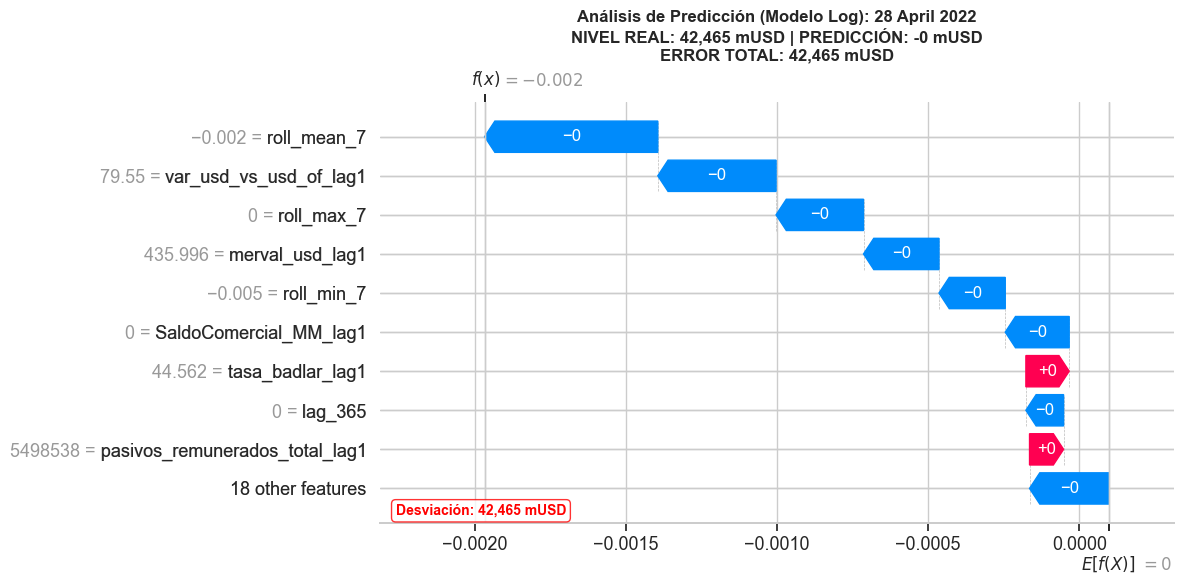


--- Insumos (Valores de entrada) que el modelo 'vio' para 2022-04-28 ---


,lag_4,lag_5,lag_6,lag_30,lag_90,lag_365,roll_std_7,roll_std_30,roll_max_7,roll_max_30,...,tasa_badlar_lag1,merval_usd_lag1,sp500_lag1,vix_index_lag1,pasivos_remunerados_total_lag1,ratio_pasivos_base_lag1,ITCRM_lag1,inflacion_mensual_oficial_lag1,EMAE_lag1,SaldoComercial_MM_lag1
2022-04-28,0.0,0.0,-0.004608,-0.002014,-0.02351,0.000223,0.002271,0.001574,0.000188,0.001848,...,44.5625,435.996,4183.959961,31.6,5498538.0,1.594131,97.493258,4.7,148.386672,2.970000e-11


In [169]:
# 1. Configuración inicial y obtención de datos
# ==============================================================================
fecha_interes = '2022-04-28'
explainer = shap.TreeExplainer(forecaster.estimator)

# Obtenemos la matriz de características
X_train, _ = forecaster.create_train_X_y(y=df['reservas'], exog=df[exog_sel])
iloc_idx = X_train.index.get_loc(fecha_interes)
fecha_exacta = X_train.index[iloc_idx]

# 2. Cálculo de SHAP values (en escala LOG)
# ==============================================================================
shap_values_single = explainer(X_train.iloc[[iloc_idx]])

# Como usas log_transformer (FunctionTransformer), no hay mean_ ni std_
# Los SHAP values representan cuánto suma cada variable al log(reservas)
shap_values_log = copy.deepcopy(shap_values_single)

# 3. Transformación a Nivel Nominal (mUSD)
# ==============================================================================
# Valor base en log -> pasar a USD
base_value_log = shap_values_log.base_values[0]
base_value_usd = np.expm1(base_value_log)

# Predicción total en log -> pasar a USD
pred_log = base_value_log + shap_values_log.values[0].sum()
pred_niv = np.expm1(pred_log)

valor_real_niv = df.loc[fecha_exacta, 'reservas']
error = valor_real_niv - pred_niv

# --- IMPORTANTE PARA EL GRÁFICO ---
# Para que el Waterfall tenga sentido visual en USD, aplicamos una 
# aproximación: contribución_usd = pred_total_usd * (shap_value_log)
# Esto reparte el valor predicho según los pesos logarítmicos.
shap_values_usd = copy.deepcopy(shap_values_log)
# Aproximación de impacto en niveles:
total_shap_log = shap_values_log.values[0].sum()
if total_shap_log != 0:
    # Proporcionalidad del impacto logarítmico sobre la diferencia nivel - base
    shap_values_usd.values = (shap_values_log.values * (pred_niv - base_value_usd) / total_shap_log)
    
shap_values_usd.base_values = np.array([base_value_usd])

# 4. Gráfico Waterfall de Niveles
# ==============================================================================
shap.plots.waterfall(shap_values_usd[0], show=False)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(12, 6)

titulo = (
    f"Análisis de Predicción (Modelo Log): {fecha_exacta.strftime('%d %B %Y')}\n"
    f"NIVEL REAL: {valor_real_niv:,.0f} mUSD | PREDICCIÓN: {pred_niv:,.0f} mUSD\n"
    f"ERROR TOTAL: {error:,.0f} mUSD"
)
ax.set_title(titulo, fontsize=12, fontweight='bold', pad=30)

# Anotación visual del error
color_err = 'green' if abs(error) < 500 else 'red'
ax.annotate(f"Desviación: {error:,.0f} mUSD", 
            xy=(0.02, 0.02), xycoords='axes fraction',
            fontsize=10, fontweight='bold', color=color_err,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color_err, alpha=0.8))

plt.tight_layout()
plt.show()

# 5. Tabla de Insumos (Valores originales)
# ==============================================================================
print(f"\n--- Insumos (Valores de entrada) que el modelo 'vio' para {fecha_exacta.date()} ---")
df_insumos = pd.DataFrame(
    shap_values_usd[0].data.reshape(1, -1), 
    columns = X_train.columns,
    index = [fecha_exacta]
)
display(df_insumos)

In [170]:
# Entrenar el forecaster final con lo seleccionado (si no lo hiciste antes)
forecaster.fit(
    y    = df.loc[:fin_validacion, 'reservas'], 
    exog = df.loc[:fin_validacion, exog_sel]
)

# Crear el explainer con el modelo YA ENTRENADO
explainer = shap.TreeExplainer(forecaster.estimator)

In [171]:
# 1. Calculamos las métricas
mse = mean_squared_error(df.loc[predicciones.index, 'reservas'], predicciones['pred'])
rmse = np.sqrt(mse)

# 2. Calculamos el MAPE (error porcentual absoluto medio)
real = df.loc[predicciones.index, 'reservas']
pred = predicciones['pred']
mape = np.mean(np.abs((real - pred) / real)) * 100

# 3. Error relativo (MAE como % de la media de reservas)
media_reservas = real.mean()
mae_porcentaje = (metrica.iloc[0, 0] / media_reservas) * 100

# 4. Tabla actualizada
resumen_tesis = pd.DataFrame({
    'Métrica': ['MAE', 'MAE (%)', 'RMSE', 'MAPE', 'Cobertura (90%)', 'Ancho Promedio Banda'],
    'Valor': [
        f"{metrica.iloc[0, 0]:.2f} mUSD",
        f"{mae_porcentaje:.2f}%",
        f"{rmse:.2f} mUSD", 
        f"{mape:.2f}%",
        f"{100 * cobertura_niveles:.2f}%", 
        f"{(predicciones['upper_bound'] - predicciones['lower_bound']).mean():.2f} mUSD"
    ]
})

display(resumen_tesis)

,Métrica,Valor
0,MAE,155.53 mUSD
1,MAE (%),0.35%
2,RMSE,636.82 mUSD
3,MAPE,0.35%
4,Cobertura (90%),85.05%
5,Ancho Promedio Banda,401.00 mUSD


In [172]:
# REFIT MEJORA PREDICCION A LARGO PLAZO PERO PRINCIPALMENTE PODRIA SER RIESGO DE SOBREAJUSTE PUEDE QUE CON UNA MAYOR CANTIDAD DE DATOS SE PUEDA QUE SE AJUSTE MUCHO A LOS DATOS Y NO SEA GENERALIZABLE

In [173]:
# Test de Ljung-Box sobre los residuos
# Si p-value > 0.05, felicidades: tus residuos son Ruido Blanco (independientes)
res_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print("Test de Ljung-Box (Ruido Blanco):")
display(res_test)

Test de Ljung-Box (Ruido Blanco):


,lb_stat,lb_pvalue
10,21.843469,0.015922


# No se que tanto suma esto

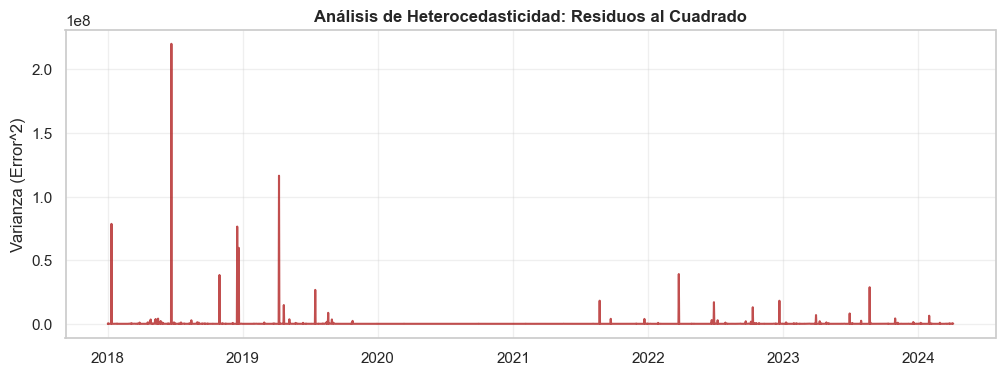

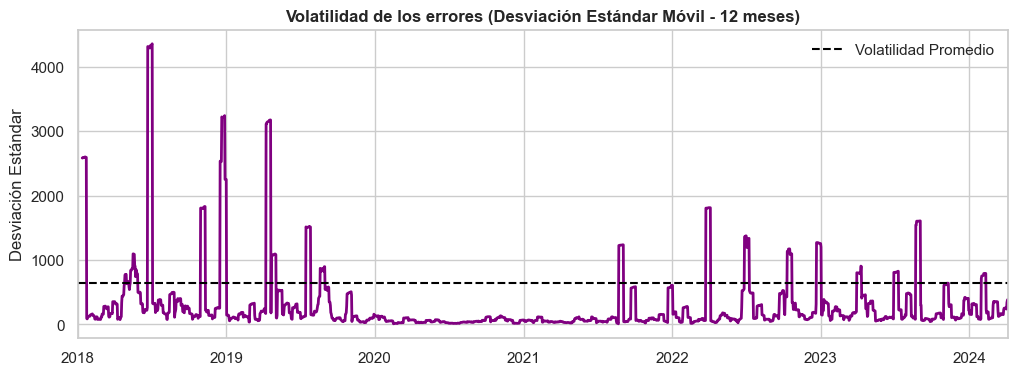

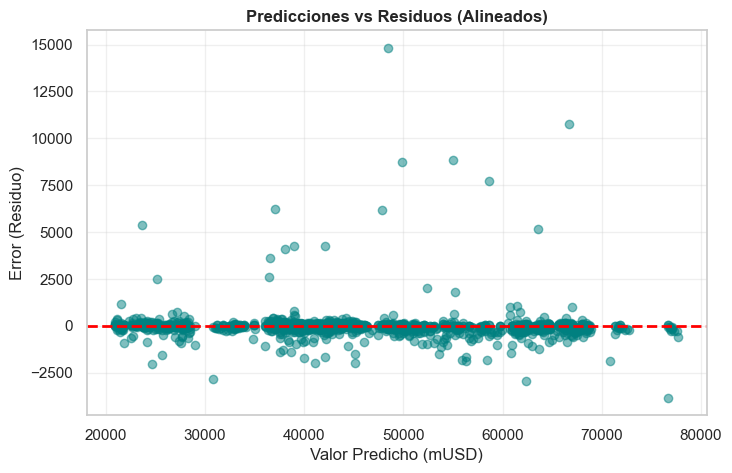

Tamaño predicciones: 2287
Tamaño residuos: 2287


In [174]:
# 1. Gráfico de Residuos al Cuadrado (Resalta la volatilidad)
# ==============================================================================
plt.figure(figsize=(12, 4))
plt.plot(residuals**2, color='firebrick', alpha=0.8)
plt.title("Análisis de Heterocedasticidad: Residuos al Cuadrado", fontsize=12, fontweight='bold')
plt.ylabel("Varianza (Error^2)")
plt.grid(True, alpha=0.3)
plt.show()

# 2. Volatilidad Móvil (Desviación Estándar de los errores a 12 meses)
# ==============================================================================
plt.figure(figsize=(12, 4))
residuals.rolling(window=12).std().plot(color='purple', linewidth=2)
plt.title("Volatilidad de los errores (Desviación Estándar Móvil - 12 meses)", fontsize=12, fontweight='bold')
plt.ylabel("Desviación Estándar")
plt.axhline(y=residuals.std(), color='black', linestyle='--', label='Volatilidad Promedio')
plt.legend()
plt.show()

# 1. Alineamos las predicciones y los residuos usando el índice común
# ==============================================================================
# Buscamos las fechas que están presentes en ambos objetos
indices_comunes = predicciones.index.intersection(residuals.index)

# Filtramos ambos para que tengan el mismo tamaño y orden
pred_plot = predicciones.loc[indices_comunes, 'pred']
res_plot = residuals.loc[indices_comunes]

# 2. Ahora graficamos sin el error de tamaño
# ==============================================================================
plt.figure(figsize=(8, 5))
plt.scatter(pred_plot, res_plot, alpha=0.5, color='teal')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title("Predicciones vs Residuos (Alineados)", fontsize=12, fontweight='bold')
plt.xlabel("Valor Predicho (mUSD)")
plt.ylabel("Error (Residuo)")
plt.grid(True, alpha=0.3)
plt.show()

# Verificación rápida por consola
print(f"Tamaño predicciones: {len(pred_plot)}")
print(f"Tamaño residuos: {len(res_plot)}")

Análisis de heterocedasticidad mediante residuos al cuadrado. Se observa la presencia de clustering de volatilidad, evidenciado por la agrupación de valores elevados en períodos específicos (mediados de 2022, 2023 y 2025). 
Los residuos exhiben clustering de volatilidad: períodos de errores elevados tienden a agruparse, al igual que los períodos de errores reducidos, indicando que la varianza condicional de los errores no es constante

Volatilidad de los residuos medida como desviación estándar móvil con ventana de 12 meses. La línea punteada representa la volatilidad promedio del período. Se identifican tres regímenes diferenciados: alta volatilidad durante 2023 (errores por encima del promedio), baja volatilidad en 2024-inicios de 2025 (mayor precisión del modelo), y un incremento posterior hacia mediados de 2025. Esta dinámica temporal refuerza la evidencia de heterocedasticidad y justifica la exploración de modelos que capturen la variabilidad condicional de la varianza.

Diagrama de dispersión entre valores predichos y residuos del modelo. Los puntos se distribuyen de manera aleatoria alrededor de la línea de referencia (y=0), sin evidenciar un patrón sistemático de "abanico" u otra estructura. Esto indica que la magnitud de los errores no depende del nivel de la variable predicha, descartando heterocedasticidad asociada al valor de la predicción. No obstante, este resultado no contradice la heterocedasticidad temporal observada en las figuras anteriores.